In [1]:
from google.colab import drive
import os, pathlib
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import layers, models, Input

In [2]:
drive.mount('/content/drive')

REPO_URL   = "https://github.com/Svanzi/Tennis-Shot-Recognition.git"
BASE       = "/content/drive/MyDrive/University/Deep"
SPARSE_DIR = "Tennis-Shot-Recognition"   # repo "leggera" solo per i dati
TARGET     = f"{BASE}/{SPARSE_DIR}"

os.makedirs(BASE, exist_ok=True)

# Clona in modalità sparse solo la prima volta
if not os.path.exists(TARGET):
    %cd {BASE}
    !git clone --filter=blob:none --sparse {REPO_URL} {SPARSE_DIR}
    %cd {SPARSE_DIR}
    !git sparse-checkout set DataSet
else:
    %cd {TARGET}
    !git pull

# Path da usare nel notebook
from pathlib import Path
DATA_DIR = Path(TARGET) / "DataSet"
print("DATA_DIR =", DATA_DIR)

Mounted at /content/drive
/content/drive/MyDrive/University/Deep/Tennis-Shot-Recognition
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 731 bytes | 11.00 KiB/s, done.
Resolving deltas: 100% (3/3), completed with 1 local object.
From https://github.com/Svanzi/Tennis-Shot-Recognition
   3770edf..28f9509  main       -> origin/main
Updating 3770edf..28f9509
Fast-forward
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (1/1), 60.13 KiB | 1.54 MiB/s, done.
 Shot_Classification.ipynb | 530 +++++++++++++++++++++++++++++++++++-----------
 1 file changed, 402 insertions(+), 128 deletions(-)
DATA_DIR = /content/drive/MyDrive/University/Deep/Tennis-Shot-Recognition/DataSet


# Sequence creation

In [28]:
def idx_of(prefixes):
  idx = []
  for p in prefixes:
    for suff in ['_x','_y']:
      name = p + suff
      if name in cols:
        idx.append(cols.get_loc(name))
  return idx

In [ ]:
DATA_DIR = Path("/content/drive/MyDrive/University/Deep/Tennis-Shot-Recognition/DataSet")
players = sorted([p for p in DATA_DIR.iterdir() if p.is_dir()])

feature_cols = None
sequences = []        # List of dict: {"left_arm": (T,6), "right_arm":..., "torso":(T,8)}
sequence_labels = []  # A label for each CSV

for player in tqdm(players):
  for shot_csv in sorted(player.glob("*.csv")):
    df = pd.read_csv(shot_csv)
    if feature_cols is None:
      feature_cols = pd.Index([c for c in df.columns if c!= 'shot'])

Versione alternativa

In [8]:
DATA_DIR = Path("/content/drive/MyDrive/University/Deep/Tennis-Shot-Recognition/DataSet")
players = sorted([p for p in DATA_DIR.iterdir() if p.is_dir()])

X, Y = [], []

X_test, y_test = [], []

first = True
feature_cols = None

for player in tqdm(players, desc="Players", leave=False):
    print(f"\n**** Parsing the shots of {player.name} ****\n")
    for shot_csv in sorted(player.glob("*.csv")):
        print(shot_csv.name)
        data = pd.read_csv(shot_csv)

        if first:
          feature_cols = [c for c in data.columns if c!= 'shot']
          first = False
        else:
          assert feature_cols == [c for c in data.columns if c != 'shot'], f"Colonne diverse in {shot_csv}"

        # --- Split 80/20 ---

        data_train = data[:int(0.8*len(data))]
        data_test = data[int(0.8*len(data)):]

        X.extend(data_train[feature_cols].to_numpy())
        Y.extend(data_train["shot"].to_numpy().flatten())

        X_test.extend(data_test[feature_cols].to_numpy())
        y_test.extend(data_test["shot"].to_numpy().flatten())

X = np.stack(X, axis=0)
Y = np.array(Y)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("\n\n")
print(f"Loaded {len(Y)} shots for training")
print(f"Loaded {len(y_test)} shots for test")

Players:   0%|          | 0/2 [00:00<?, ?it/s]


**** Parsing the shots of Alcaraz ****

backhand_001.csv
backhand_002.csv
backhand_003.csv
backhand_004.csv
backhand_005.csv
backhand_006.csv
backhand_007.csv
forehand_001.csv
forehand_002.csv
forehand_003.csv
forehand_004.csv
forehand_005.csv
forehand_006.csv
forehand_007.csv
forehand_008.csv
forehand_009.csv
forehand_010.csv
forehand_011.csv
forehand_012.csv
forehand_013.csv
forehand_014.csv
forehand_015.csv
forehand_016.csv
forehand_017.csv
forehand_018.csv
forehand_019.csv
forehand_020.csv
forehand_021.csv
forehand_022.csv
forehand_023.csv
forehand_024.csv
forehand_025.csv
forehand_026.csv
forehand_027.csv
forehand_028.csv
forehand_029.csv
forehand_030.csv
neutral_001.csv
neutral_002.csv
neutral_003.csv
neutral_004.csv
neutral_005.csv
neutral_006.csv
neutral_007.csv
neutral_008.csv
neutral_009.csv
neutral_010.csv
neutral_011.csv
neutral_012.csv
neutral_013.csv
neutral_014.csv
neutral_015.csv
neutral_016.csv
neutral_017.csv
neutral_018.csv
neutral_019.csv
neutral_020.csv
neutral_02

Players:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s]

neutral_029.csv
neutral_030.csv
neutral_031.csv
neutral_032.csv
neutral_033.csv
neutral_034.csv
neutral_035.csv
neutral_036.csv

**** Parsing the shots of Sinner ****

backhand_001.csv
backhand_002.csv
backhand_003.csv
backhand_004.csv
backhand_005.csv
backhand_006.csv
backhand_007.csv
backhand_008.csv
forehand_001.csv
forehand_002.csv
forehand_003.csv
forehand_004.csv
forehand_005.csv
forehand_006.csv
forehand_007.csv
forehand_008.csv
forehand_009.csv
forehand_010.csv
forehand_011.csv
forehand_012.csv
forehand_013.csv
forehand_014.csv
forehand_015.csv
forehand_016.csv
forehand_017.csv
forehand_018.csv
forehand_019.csv
forehand_020.csv
forehand_021.csv
forehand_022.csv
forehand_023.csv
forehand_024.csv
forehand_025.csv
forehand_026.csv
neutral_001.csv
neutral_002.csv
neutral_003.csv
neutral_004.csv
neutral_005.csv
neutral_006.csv
neutral_007.csv
neutral_008.csv
neutral_009.csv
neutral_010.csv
neutral_011.csv
neutral_012.csv
neutral_013.csv
neutral_014.csv
neutral_015.csv
neutral_016.cs

neutral_022.csv
neutral_023.csv
neutral_024.csv
neutral_025.csv
neutral_026.csv
neutral_027.csv
neutral_028.csv
neutral_029.csv
neutral_030.csv
neutral_031.csv
neutral_032.csv
neutral_033.csv



Loaded 3360 shots for training
Loaded 980 shots for test


In [9]:
import re

cols = pd.Index(feature_cols)

def idx_of(prefixes):
  idx = []
  for p in prefixes:
    for suff in ['_x','_y']:
      name = p + suff
      if name in cols:
        idx.append(cols.get_loc(name))
  return idx

GROUPS = {
    'left_arm':   idx_of(['left_shoulder',  'left_elbow',   'left_wrist'                        ]),
    'right_arm':  idx_of(['right_shoulder', 'right_elbow',  'right_wrist'                       ]),
    'left_leg':   idx_of(['left_hip',       'left_knee',    'left_ankle'                        ]),
    'right_leg':  idx_of(['right_hip',      'right_knee',   'right_ankle'                       ]),
    'torso':      idx_of(['left_hip',       'right_hip',     'left_shoulder',  'right_shoulder' ])
}

In [10]:
X_parts      = {name: X[:, idx] for name, idx in GROUPS.items()}
X_test_parts = {name: X_test[:, idx] for name, idx in GROUPS.items()}
display(print(X_parts['torso'].shape))
display(print(X_parts['left_arm'].shape))
display(print(X_parts['right_arm'].shape))
display(print(X_parts['left_leg'].shape))
display(print(X_parts['right_leg'].shape))

(3360, 8)


None

(3360, 6)


None

(3360, 6)


None

(3360, 6)


None

(3360, 6)


None

# SALTALO PER ORA

In [6]:
DATA_DIR = Path("/content/drive/MyDrive/University/Deep/Tennis-Shot-Recognition/DataSet")
players = sorted([p for p in DATA_DIR.iterdir() if p.is_dir()])

X=[]
Y=[]
X_test=[]
y_test=[]

for player in tqdm(players, desc="Players", leave=False):
    print(f"\n**** Parsing the shots of {player.name} ****\n")
    for shot_csv in sorted(player.glob("*.csv")):
        print(shot_csv.name)
        data = pd.read_csv(shot_csv)

        data_train = data[:int(0.8*len(data))]
        data_test = data[int(0.8*len(data)):]

        features_train = list(data_train.loc[:, data.columns != 'shot'].to_numpy())
        features_test = list(data_test.loc[:, data.columns != 'shot'].to_numpy())

        X.extend(features_train)
        Y.extend(data_train["shot"].to_numpy().flatten())

        X_test.extend(features_test)
        y_test.extend(data_test["shot"].to_numpy().flatten())

X = np.stack(X, axis=0)
X = np.array(X)
Y = np.array(Y)
y_test = np.array(y_test)

print("\n\n")
print(f"Loaded {len(Y)} shots for training")
print(f"Loaded {len(y_test)} shots for test")

Players:   0%|          | 0/2 [00:00<?, ?it/s]


**** Parsing the shots of Alcaraz ****

backhand_001.csv
backhand_002.csv
backhand_003.csv
backhand_004.csv
backhand_005.csv
backhand_006.csv
backhand_007.csv
forehand_001.csv
forehand_002.csv
forehand_003.csv
forehand_004.csv
forehand_005.csv
forehand_006.csv
forehand_007.csv
forehand_008.csv
forehand_009.csv
forehand_010.csv
forehand_011.csv
forehand_012.csv
forehand_013.csv
forehand_014.csv
forehand_015.csv
forehand_016.csv
forehand_017.csv
forehand_018.csv
forehand_019.csv
forehand_020.csv
forehand_021.csv
forehand_022.csv
forehand_023.csv
forehand_024.csv
forehand_025.csv
forehand_026.csv
forehand_027.csv
forehand_028.csv
forehand_029.csv
forehand_030.csv
neutral_001.csv
neutral_002.csv
neutral_003.csv
neutral_004.csv
neutral_005.csv
neutral_006.csv
neutral_007.csv
neutral_008.csv
neutral_009.csv
neutral_010.csv
neutral_011.csv
neutral_012.csv
neutral_013.csv
neutral_014.csv
neutral_015.csv
neutral_016.csv
neutral_017.csv
neutral_018.csv
neutral_019.csv
neutral_020.csv
neutral_02

Players:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s]

neutral_033.csv
neutral_034.csv
neutral_035.csv
neutral_036.csv

**** Parsing the shots of Sinner ****

backhand_001.csv
backhand_002.csv
backhand_003.csv
backhand_004.csv
backhand_005.csv
backhand_006.csv
backhand_007.csv
backhand_008.csv
forehand_001.csv
forehand_002.csv
forehand_003.csv
forehand_004.csv
forehand_005.csv
forehand_006.csv
forehand_007.csv
forehand_008.csv
forehand_009.csv
forehand_010.csv
forehand_011.csv
forehand_012.csv
forehand_013.csv
forehand_014.csv
forehand_015.csv
forehand_016.csv
forehand_017.csv
forehand_018.csv
forehand_019.csv
forehand_020.csv
forehand_021.csv
forehand_022.csv
forehand_023.csv
forehand_024.csv
forehand_025.csv
forehand_026.csv
neutral_001.csv
neutral_002.csv
neutral_003.csv
neutral_004.csv
neutral_005.csv
neutral_006.csv
neutral_007.csv
neutral_008.csv
neutral_009.csv
neutral_010.csv
neutral_011.csv
neutral_012.csv
neutral_013.csv
neutral_014.csv
neutral_015.csv
neutral_016.csv
neutral_017.csv
neutral_018.csv
neutral_019.csv
neutral_020.cs

neutral_033.csv



Loaded 3360 shots for training
Loaded 980 shots for test


In [ ]:
print(X)

[[0.47537094 0.42198735 0.480145   ... 0.43361482 0.7864063  0.4828802 ]
 [0.4759235  0.4219989  0.47949362 ... 0.43354845 0.7880765  0.47143674]
 [0.47548828 0.4219664  0.47920176 ... 0.43335754 0.79009086 0.45664233]
 ...
 [0.45424196 0.34041843 0.4637692  ... 0.31002524 0.77155685 0.3890084 ]
 [0.45499817 0.34166566 0.46419644 ... 0.31127426 0.7705901  0.39130765]
 [0.4561     0.34284395 0.4648346  ... 0.3112963  0.7706611  0.39440447]]


# Print

In [11]:
# Robust counts (and sorted)
shots, counts = np.unique(Y, return_counts=True)
order = np.argsort(counts)[::-1]
shots, counts = shots[order], counts[order]

def pie_plot(shots, counts):

  fig, ax = plt.subplots()

  # Pie with percentages
  wedges, texts, autotexts = ax.pie(
      counts,
      autopct='%1.1f%%',
      startangle=90
  )

  ax.axis('equal')
  ax.set_title('Shots dataset')

  # Legend on the side with "label — count"
  legend_labels = [f"{label} — {cnt}" for label, cnt in zip(shots, counts)]
  ax.legend(
      wedges, legend_labels,
      title="Shots (counts)",
      loc="center left",
      bbox_to_anchor=(1.02, 0.5),
      frameon=False
  )

  plt.tight_layout()
  plt.show()

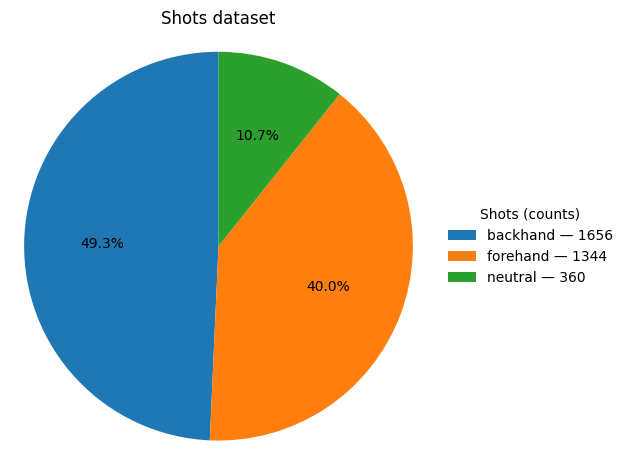

In [14]:
pie_plot(shots, counts)

In [12]:
# Take backhand occurences and cap all other classes to this value

shots = np.unique(Y)
cap = np.count_nonzero(Y == "backhand")

rng = np.random.default_rng(42)
subset_idx = []
for s in shots:
    idx = np.flatnonzero(Y == s)
    take = min(cap, idx.size)
    chosen = rng.choice(idx, size=take, replace=False)  # no duplicates
    subset_idx.append(chosen)

subset_idx = np.sort(np.concatenate(subset_idx))

equalized_X = X[subset_idx]
equalized_Y = Y[subset_idx]

equalized_occurences = [np.count_nonzero(equalized_Y == shot) for shot in shots]

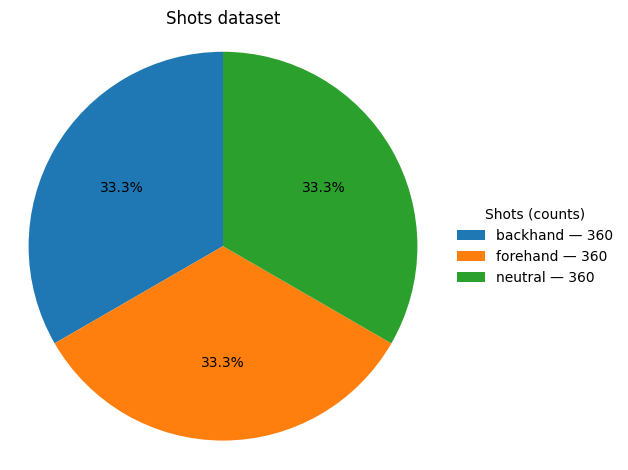

In [13]:
pie_plot(shots, equalized_occurences)

# Data Splitting

In [15]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(equalized_X, equalized_Y, test_size=0.33, shuffle= False)



print(f"Shape of train features : {X_train[0].shape}")
print(f"Shape of val features : {X_val[0].shape}")


print("Total categories: ", len(np.unique(y_train)))
print("Total categories: ", len(np.unique(y_val)))

nb_cat = len(np.unique(y_train))

Shape of train features : (24,)
Shape of val features : (24,)
Total categories:  3
Total categories:  3


In [16]:
le = preprocessing.LabelEncoder()


y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

n_classes = len(le.classes_)

y_train = tf.keras.utils.to_categorical(y_train,  num_classes=n_classes)
y_val   = tf.keras.utils.to_categorical(y_val,    num_classes=n_classes)
y_test  = tf.keras.utils.to_categorical(y_test,   num_classes=n_classes)

y_train = np.array(y_train)
X_train = np.array(X_train)

y_val = np.array(y_val)
X_val = np.array(X_val)

y_test = np.array(y_test)
X_test = np.array(X_test)

In [17]:
print(list(le.classes_))

[np.str_('backhand'), np.str_('forehand'), np.str_('neutral')]


In [18]:
print("X_train Shape: ", X_train.shape)
print("X_val Shape: ", X_val.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_val Shape: ", y_val.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (723, 24)
X_val Shape:  (357, 24)
X_test Shape:  (980, 24)
y_train Shape:  (723, 3)
y_val Shape:  (357, 3)
y_test Shape:  (980, 3)


# Model

In [19]:
def brnn_tanh(units, name, rnn_type="simple", dropout=0.0, return_sequences=True):
  if rnn_type == "simple":
    rnn = layers.SimpleRNN(units, activation='tanh', return_sequences=return_sequences, dropout=dropout)

  elif rnn_type == "gru":
    rnn = layers.GRU(units, activation='tanh', return_sequences=return_sequences, dropout=dropout)

  return layers.Bidirectional(rnn, name=name)

In [20]:
def  bidirectional_lstm(units, name, dropout=0.0, return_sequences=False):
  lstm = layers.LSTM(units, return_sequences=return_sequences, dropout=dropout)
  return layers.Bidirectional(lstm, name=name)

In [25]:
def create_network(
    T=30,
    shape_left_arm=6,
    shape_right_arm=6,
    shape_left_leg=6,
    shape_right_leg=6,
    shape_trunk=8,
    n_classes=3,
    brnn_units=(64, 96, 128),
    lstm_units=256,
    rnn_type="simple",
    dropout=0.1
):

  # ==== Inputs ====

  in_left_arm  = Input(shape=(T, shape_left_arm),  name = "left_arm")
  in_right_arm = Input(shape=(T, shape_right_arm), name = "right_arm")
  in_left_leg  = Input(shape=(T, shape_left_leg),  name = "left_leg")
  in_right_leg = Input(shape=(T, shape_right_leg), name = "right_leg")
  in_trunk     = Input(shape=(T, shape_trunk),     name = "trunk")

  # ==== bl1 layer ====

  bl1_left_arm  =  brnn_tanh(brnn_units[0], "bl1_left_arm",   rnn_type, dropout)  (in_left_arm)
  bl1_right_arm =  brnn_tanh(brnn_units[0], "bl1_right_arm",  rnn_type, dropout)  (in_right_arm)
  bl1_trunk     =  brnn_tanh(brnn_units[0], "bl1_trunk",      rnn_type, dropout)  (in_trunk)
  bl1_left_leg  =  brnn_tanh(brnn_units[0], "bl1_left_leg",   rnn_type, dropout)  (in_left_leg)
  bl1_right_leg =  brnn_tanh(brnn_units[0], "bl1_right_leg",  rnn_type, dropout)  (in_right_leg)

  # ==== fl1 layer ====

  fl1_leftArm_trunk   = layers.Concatenate(name="fl1_leftArm_trunk")  ([bl1_left_arm,   bl1_trunk])
  fl1_rightArm_trunk  = layers.Concatenate(name="fl1_rightArm_trunk") ([bl1_right_arm,  bl1_trunk])
  fl1_leftLeg_trunk   = layers.Concatenate(name="fl1_lafetLeg_trunk") ([bl1_left_leg,   bl1_trunk])
  fl1_rightLeg_trunk  = layers.Concatenate(name="fl1_rightLeg_trunk") ([bl1_right_leg,  bl1_trunk])

  # ==== bl2 layer ====

  bl2_leftArm_trunk   = brnn_tanh(brnn_units[1], "bl2_leftArm_trunk",   rnn_type, dropout)  (fl1_leftArm_trunk)
  bl2_rightArm_trunk  = brnn_tanh(brnn_units[1], "bl2_rightArm_trunk",  rnn_type, dropout)  (fl1_rightArm_trunk)
  bl2_leftLeg_trunk   = brnn_tanh(brnn_units[1], "bl2_leftLeg_trunk",   rnn_type, dropout)  (fl1_leftLeg_trunk)
  bl2_rightLeg_trunk  = brnn_tanh(brnn_units[1], "bl2_rightLeg_trunk",  rnn_type, dropout)  (fl1_rightLeg_trunk)

  # ==== fl2 layer ====

  fl2_upperBody = layers.Concatenate(name="fl2_upperBody")  ([bl2_leftArm_trunk,  bl2_rightArm_trunk])
  fl2_lowerBody = layers.Concatenate(name="fl2_lowerBody")  ([bl2_leftLeg_trunk,  bl2_rightLeg_trunk])

  # ==== bl3 layer ====

  bl3_upperBody = brnn_tanh(brnn_units[2], "bl3_upperBody", rnn_type, dropout)  (fl2_upperBody)
  bl3_lowerBody = brnn_tanh(brnn_units[2], "bl3_lowerBody", rnn_type, dropout)  (fl2_lowerBody)

  # ==== fl3 layer ====

  fl3_wholeBody = layers.Concatenate(name="fl3_wholeBody") ([bl3_upperBody, bl3_lowerBody])

  # ==== bl4 layer ====

  bl4 = bidirectional_lstm(lstm_units, "bl4", dropout, return_sequences=False) (fl3_wholeBody)

  # ==== fully connected layer ====

  fc = layers.Dense(256, activation='relu', name="fc")(bl4)
  fc = layers.Dropout(0.3)(fc)

  # ==== softmax layer ====

  sl = layers.Dense(n_classes, activation="softmax", name="sl")(fc)

  model = models.Model(
      inputs=[in_left_arm, in_right_arm, in_trunk, in_left_leg, in_right_leg],
      outputs= sl,
      )

  return model

In [27]:
model = create_network(
    T=30,
    shape_left_arm=6,
    shape_right_arm=6,
    shape_left_leg=6,
    shape_right_leg=6,
    shape_trunk=8,
    n_classes=3,
    brnn_units=(64, 96, 128),
    lstm_units=256,
    rnn_type="simple",
    dropout=0.1
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_arm            │ (None, 30, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trunk (InputLayer)  │ (None, 30, 8)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_arm           │ (None, 30, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left_leg            │ (None, 30, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_leg           │ (None, 30, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl1_left_arm        │ (None, 30, 128)   │      9,088 │ left_arm[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl1_trunk           │ (None, 30, 128)   │      9,344 │ trunk[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl1_right_arm       │ (None, 30, 128)   │      9,088 │ right_arm[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl1_left_leg        │ (None, 30, 128)   │      9,088 │ left_leg[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl1_right_leg       │ (None, 30, 128)   │      9,088 │ right_leg[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fl1_leftArm_trunk   │ (None, 30, 256)   │          0 │ bl1_left_arm[0][… │
│ (Concatenate)       │                   │            │ bl1_trunk[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fl1_rightArm_trunk  │ (None, 30, 256)   │          0 │ bl1_right_arm[0]… │
│ (Concatenate)       │                   │            │ bl1_trunk[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fl1_lafetLeg_trunk  │ (None, 30, 256)   │          0 │ bl1_left_leg[0][… │
│ (Concatenate)       │                   │            │ bl1_trunk[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fl1_rightLeg_trunk  │ (None, 30, 256)   │          0 │ bl1_right_leg[0]… │
│ (Concatenate)       │                   │            │ bl1_trunk[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl2_leftArm_trunk   │ (None, 30, 192)   │     67,776 │ fl1_leftArm_trun… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl2_rightArm_trunk  │ (None, 30, 192)   │     67,776 │ fl1_rightArm_tru… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl2_leftLeg_trunk   │ (None, 30, 192)   │     67,776 │ fl1_lafetLeg_tru… │
│ (Bidirectional)     │                   │            │                 

 Total params: 2,286,467 (8.72 MB)

 Trainable params: 2,286,467 (8.72 MB)

 Non-trainable params: 0 (0.00 B)